In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt  # 新增：用于可视化


In [65]:
import numpy as np
import random

class PatrolEnvTimeUnified:
    """
    改进版的安保巡逻环境：
      - 有 3 个主地点: 0->L0, 1->L1, 2->Home
      - 当执行 "Go L0" 或 "Go L1" 或 "Go Home" 时，会用子时间步(sub-steps)来模拟实际行走时间
      - 在每个子时间步内，警报 AoMA、警报产生、电量消耗等都会被更新
      - 这样就实现了“移动过程中 AoMA 也会持续增长、能耗也随时间分步扣除”的效果
    """
    def __init__(self,
                 # ---- 警报产生概率 ----
                 p0=0.05, p1=0.05,
                 # ---- 时间 / 能量设置 ----
                 # time_xxx_yyy 表示从 xxx -> yyy 需要多少子时间步
                 # energy_xxx_yyy 表示从 xxx -> yyy 的总能耗（会在子步中分摊）
                 time_home_l0=3, energy_home_l0=3,
                 time_home_l1=4, energy_home_l1=4,
                 time_l0_l1=2,   energy_l0_l1=2,
                 # ---- 其它能耗 / 充电设置 ----
                 idle_cost=1,           # 在 L0/L1 等待时每子步消耗
                 charge_rate=5,         # 在 Home 等待每子步充多少电
                 battery_capacity=20,   # 电池容量
                 b_safe=5,              # 低电量阈值
                 # ---- AoMA / 奖励参数 ----
                 beta=1.5,   # 未处理警报的按步负奖励系数
                 gamma=20,  # 低电量惩罚
                 M=200,       # 抛锚大惩罚
                 rho=20,    # 清除警报时的小正奖励
                 max_aoma=40, # AoMA 上限 (避免数字过大)
                 max_steps=500, # 每个 Episode 的最大(大)步数(Agent层面的步数)
                 seed=0
                 ):
        print("rho:",rho)
        print("抛锚惩罚:",M)
        self.anchor_fail = False  # 用于记录是否抛锚

        random.seed(seed)
        np.random.seed(seed)
        self.rng = np.random.RandomState(seed)

        # 警报概率
        self.p0 = p0
        self.p1 = p1

        # 移动时间与能耗矩阵 (可以根据需要扩充)
        # 这里简单处理：从 i->j 的时间 & 能耗与 j->i 相同
        self.time_home_l0 = time_home_l0
        self.energy_home_l0 = energy_home_l0
        self.time_home_l1 = time_home_l1
        self.energy_home_l1 = energy_home_l1
        self.time_l0_l1   = time_l0_l1
        self.energy_l0_l1 = energy_l0_l1

        self.idle_cost = idle_cost
        self.charge_rate = charge_rate
        self.battery_capacity = battery_capacity
        self.b_safe = b_safe

        self.beta = beta
        self.gamma = gamma
        self.M = M
        self.rho = rho
        self.max_aoma = max_aoma
        self.max_steps = max_steps
        self.current_step = 0  # 大步计数(Agent每执行一次env.step就+1)

        # 状态： AoMA_0, AoMA_1, loc ∈ {0,1,2}, battery
        self.state_dim = 4
        # 动作：0->Go L0, 1->Go L1, 2->Go Home, 3->Wait
        self.action_space = 4

        self.reset()

    def reset(self):
        """重置环境到初始状态，返回初始观测"""
        self.AoMA_0 = 0
        self.AoMA_1 = 0
        self.loc = 2  # 初始在Home
        self.battery = self.battery_capacity
        self.current_step = 0
        self.anchor_fail = False  # 每次重置时清除抛锚标记
        return self._get_state()

    def _get_state(self):
        return np.array([self.AoMA_0, self.AoMA_1, self.loc, self.battery], dtype=float)

    def step(self, action):
        """
        执行动作，并做多次“子时间步”循环:
          - 例如, "Go L1" 如果 time_home_l1 = 4, 就子循环4次
          - 每个子时间步中, 更新警报(产生/累加AoMA), 更新电量, 检查抛锚
          - 全部子时间步结束后, 才真正到达目标地点
        最终返回 (next_state, reward, done, info)
        """
        self.current_step += 1  # 这里是“大步”计数(Agent每决策一次)
        done = False
        total_sub_reward = 0.0  # 累加子步的即时奖励
        info = {}

        # 1. 根据动作, 确定移动需要的子步数 sub_steps 以及每子步能耗
        if action == 0:  # Go L0
            # 分情况：从哪来？
            if self.loc == 2:  # Home->L0
                sub_steps = self.time_home_l0
                total_energy = self.energy_home_l0
            elif self.loc == 1: # L1->L0
                sub_steps = self.time_l0_l1
                total_energy = self.energy_l0_l1
            else:  # 本来就在 L0
                sub_steps = 0d'

                ''
                total_energy = 0

            # 把 total_energy 分到每个子步 (假设能整除, 否则可做浮点除)
            energy_per_step = 0
            if sub_steps > 0:
                energy_per_step = float(total_energy) / float(sub_steps)

            # 进入子步循环
            for _ in range(sub_steps):
                # 每个子步都更新警报, 电量, 奖励
                r_sub, done = self._do_sub_step(moving=True, cost=energy_per_step)
                total_sub_reward += r_sub
                if done:
                    break
            # 若没抛锚, 最终到达 L0
            if not done:
                self.loc = 0

        elif action == 1:  # Go L1
            if self.loc == 2:  # Home->L1
                sub_steps = self.time_home_l1
                total_energy = self.energy_home_l1
            elif self.loc == 0: # L0->L1
                sub_steps = self.time_l0_l1
                total_energy = self.energy_l0_l1
            else:  # 本来就在L1
                sub_steps = 0
                total_energy = 0

            energy_per_step = 0
            if sub_steps > 0:
                energy_per_step = float(total_energy)/float(sub_steps)

            for _ in range(sub_steps):
                r_sub, done = self._do_sub_step(moving=True, cost=energy_per_step)
                total_sub_reward += r_sub
                if done:
                    break
            if not done:
                self.loc = 1

        elif action == 2:  # Go Home
            if self.loc == 0:
                sub_steps = self.time_home_l0
                total_energy = self.energy_home_l0
            elif self.loc == 1:
                sub_steps = self.time_home_l1
                total_energy = self.energy_home_l1
            else:
                sub_steps = 0
                total_energy = 0

            energy_per_step = 0
            if sub_steps > 0:
                energy_per_step = float(total_energy)/float(sub_steps)

            for _ in range(sub_steps):
                r_sub, done = self._do_sub_step(moving=True, cost=energy_per_step)
                total_sub_reward += r_sub
                if done:
                    break
            if not done:
                self.loc = 2

        elif action == 3:  # Wait
            # 等待 1 个子步
            # 在 Home 等待 => 充电; 在 L0/L1 等待 => idle_cost
            r_sub, done = self._do_sub_step(moving=False, cost=self.idle_cost)
            total_sub_reward += r_sub
        else:
            raise ValueError("Invalid action!")

        # 2. 如果在子步中已经 done，就直接返回
        if done:
            info["anchor_fail"] = self.anchor_fail
            return self._get_state(), total_sub_reward, True, info

        # 3. 如果移动成功抵达了有警报的地点 => 清除警报 => +rho (一次性的)
        reward_clear = 0.0
        if self.loc == 0 and self.AoMA_0 > 0:
            self.AoMA_0 = 0
            reward_clear += self.rho
        if self.loc == 1 and self.AoMA_1 > 0:
            self.AoMA_1 = 0
            reward_clear += self.rho

        # 4. 把清除警报的奖励加上
        total_sub_reward += reward_clear

        # 5. 最后再判断是否超过最大大步数
        if self.current_step >= self.max_steps:
            done = True
        
        info["anchor_fail"] = self.anchor_fail
        return self._get_state(), total_sub_reward, done, info

    def _do_sub_step(self, moving, cost):
        """
        执行一个“子时间步”：
          - 随机产生新警报
          - 未处理警报 AoMA += 1
          - 若在移动, 电量扣 cost(或 cost 的整数分配); 若在Home等待, 就充电; 若在 L0/L1 等待, 扣 idle_cost
          - 计算当下的即时奖励(未处理警报惩罚 + 低电量惩罚)
          - 如果电量不够 => 抛锚 done
        返回 (reward_sub, done)
        """
        done = False
        reward_sub = 0.0

        # a) 产生新警报(仅当 AoMA==0 的地点才可能出现新警报)
        if self.AoMA_0 == 0:
            if self.rng.rand() < self.p0:
                self.AoMA_0 = 1
        else:
            # self.AoMA_0 = min(self.AoMA_0 + 1, self.max_aoma)
            self.AoMA_0 = self.AoMA_0 + 1

        if self.AoMA_1 == 0:
            if self.rng.rand() < self.p1:
                self.AoMA_1 = 1
        else:
            # self.AoMA_1 = min(self.AoMA_1 + 1, self.max_aoma)
            self.AoMA_1 = self.AoMA_1 + 1

        # b) 根据地点 & 是否移动, 扣/加电量
        if moving:
            # 如果 cost 不是整数, 这里做个向上取整或者直接用浮点
            # 为简单起见, 这里要求 cost <= battery, 然后一次扣 cost (也可 cost=1, 循环多次)
            if self.battery < cost:
                # 抛锚
                self.anchor_fail = True #如果抛锚，标志位记录
                return -self.M, True
            else:
                self.battery -= cost
        else:
            # 不移动 => 可能在 L0/L1 等待 or Home 等待
            if self.loc in [0,1]:
                # idle_cost = cost
                if self.battery < cost:
                    return -self.M, True
                self.battery -= cost
            else:
                # 在 Home => 充电
                self.battery = min(self.battery + self.charge_rate, self.battery_capacity)

        # c) 计算该子步的即时奖励
        n_alarms = 0
        if self.AoMA_0 > 0:
            n_alarms += 1
        if self.AoMA_1 > 0:
            n_alarms += 1

        r_alarm = -self.beta * n_alarms
        r_battery = -self.gamma if self.battery < self.b_safe else 0.0

        reward_sub = r_alarm + r_battery

        return reward_sub, False


SyntaxError: invalid decimal literal (3103707409.py, line 112)

In [71]:
# -------------------------------------------------
# 2. Q 网络 (DQN)
# -------------------------------------------------
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    def forward(self, x):
        return self.net(x)


# -------------------------------------------------
# 3. DQN Agent
# -------------------------------------------------
class DQNAgent:
    def __init__(self,
                 state_dim,
                 action_dim,
                 hidden_dim=64,
                 lr=1e-3,
                 gamma=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.01,
                 epsilon_decay=5000,
                 buffer_size=50000,
                 batch_size=64,
                 seed=0):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon_end   = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.step_count = 0

        self.q_net = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_net = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # 经验回放
        self.replay_buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def select_action(self, state):
        
        
        
        # epsilon-greedy
        epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                  np.exp(-1.0 * self.step_count / self.epsilon_decay)
        self.step_count += 1

        if random.random() < epsilon:
            return random.randint(0, self.action_dim - 1)
        else:
            with torch.no_grad():
                s = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.q_net(s)
                return q_values.argmax(dim=1).item()
            
# 固定策略，用于test
    def select_action_greedy(self, state):
        """
        在测试时调用的固定策略 (无epsilon探索)。
        """
        with torch.no_grad():
            s = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_net(s)
            # 直接取 Q-value 的 argmax
            return q_values.argmax(dim=1).item()


    def store_transition(self, s, a, r, s_next, done):
        self.replay_buffer.append((s, a, r, s_next, done))

    def update(self):
        """ 从回放池采样, 用 MSELoss 更新 Q 网络 """
        if len(self.replay_buffer) < self.batch_size:
            return  # 数据不够

        batch = random.sample(self.replay_buffer, self.batch_size)
        s, a, r, s_next, done = zip(*batch)

        s      = torch.FloatTensor(s)
        a      = torch.LongTensor(a).unsqueeze(1)
        r      = torch.FloatTensor(r).unsqueeze(1)
        s_next = torch.FloatTensor(s_next)
        done   = torch.FloatTensor(done).unsqueeze(1)

        # 当前 Q
        q_pred = self.q_net(s).gather(1, a)

        # 目标 Q (用 target_net)
        with torch.no_grad():
            q_next = self.target_net(s_next).max(dim=1, keepdim=True)[0]
            q_target = r + self.gamma * q_next * (1 - done)

        loss = self.criterion(q_pred, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def soft_update(self, tau=0.01):
        """ 软更新目标网络参数: target <- tau*Q + (1-tau)*target """
        for param, param_targ in zip(self.q_net.parameters(), self.target_net.parameters()):
            param_targ.data.copy_(tau * param.data + (1 - tau) * param_targ.data)
#--------用于test--------
    def select_action_inference(self, state):
        """
        在测试(推理)阶段用纯贪心选择动作:
        不进行 epsilon 探索。
        """
        with torch.no_grad():
            s = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_net(s)  # [1, action_dim]
            action = q_values.argmax(dim=1).item()  # int
        return action




In [57]:
# -------------------------------------------------
# 4. 辅助函数: 绘制训练曲线
# -------------------------------------------------
def plot_learning_curve(reward_history, window=50):
    """
    绘制每个Episode的累计奖励, 以及滑动平均曲线
    """
    plt.figure(figsize=(8,5))
    plt.plot(reward_history, label='Episode Reward', alpha=0.4)
    
    # 计算滑动平均
    if len(reward_history) >= window:
        moving_avg = []
        cum_sum = 0
        for i, r in enumerate(reward_history):
            cum_sum += r
            if i >= window:
                cum_sum -= reward_history[i-window]
            avg = cum_sum / min(i+1, window)
            moving_avg.append(avg)
        plt.plot(moving_avg, label=f'Moving Avg({window})', color='orange')
    
    plt.title('Training Reward Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True)
    plt.show()


# -------------------------------------------------
# 5. 训练脚本(带可视化)
# -------------------------------------------------
def train_dqn(num_episodes=1000):
    env = PatrolEnvTimeUnified(
        # p0=0.05, p1=0.05,
        # E_home_l0=3, E_home_l1=3, E_l0_l1=2,
        # idle_cost=1, charge_rate=2,
        # battery_capacity=20, b_safe=5,
        # beta=1.0, gamma=2.0, M=50, rho=0.0,
        # max_aoma=50, max_steps=200,
        # seed=42
    )

    agent = DQNAgent(
        state_dim=env.state_dim,
        action_dim=env.action_space,
        hidden_dim=64, lr=1e-3,
        gamma=0.99, epsilon_start=1.0,
        epsilon_end=0.01, epsilon_decay=5000,
        buffer_size=50000, batch_size=64,
        seed=42
    )
    max_steps_per_episode = env.max_steps
    reward_history = []
    aoma_history = []

    for ep in range(num_episodes):
        s = env.reset()
        episode_reward = 0
        episode_aomas = []

        for t in range(max_steps_per_episode):
            #记录当前aoma
            current_aoma = s[0] + s[1]
            episode_aomas.append(current_aoma)
            
            #动作选择 & 环境交互
            a = agent.select_action(s)
            s_next, r, done, info = env.step(a)
            agent.store_transition(s, a, r, s_next, done)

            s = s_next
            episode_reward += r

            agent.update()
            agent.soft_update(tau=0.01)

            if done:
                break
        
        reward_history.append(episode_reward)
        # 如果不是抛锚导致的done，则记录本episode的平均AoMA
        # 注意，如果episode没到max_steps就done了，也可能是抛锚，也可能是清除完后Agent没别的事了(要看环境逻辑)。
        # 所以我们用info["anchor_fail"]来判断
        if done and "anchor_fail" in info and not info["anchor_fail"]:
            avg_aoma = np.mean(episode_aomas)
            aoma_history.append(avg_aoma)



        # 每隔一定回数打印一下信息
        if (ep+1) % 100 == 0:
            avg_reward = np.mean(reward_history[-100:])
            print(f"Episode {ep+1:4d}, AvgReward(100)={avg_reward:.2f}")

    # 绘制训练曲线
    plot_learning_curve(reward_history, window=50)

    #绘制AoMA变化趋势
    # 这里如果想看一下AoMA的变化趋势，你也可以类似绘图
    plt.figure(figsize=(8,5))
    plt.plot(aoma_history, label='Mean AoMA per Non-Anchor Episode')
    plt.title('Average AoMA Over Episodes (No Anchor Fail)')
    plt.xlabel('Episode (counted only non-anchor ones)')
    plt.ylabel('Mean AoMA')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 保存模型
    torch.save({
    "q_net": agent.q_net.state_dict(),
    "target_net": agent.target_net.state_dict(),}, "trained_agent.pth")

    return agent, reward_history


rho: 20
抛锚惩罚: 200
Episode  100, AvgReward(100)=-296.03
Episode  200, AvgReward(100)=-334.48
Episode  300, AvgReward(100)=-479.47
Episode  400, AvgReward(100)=-290.98
Episode  500, AvgReward(100)=-27.26
Episode  600, AvgReward(100)=512.02
Episode  700, AvgReward(100)=694.58
Episode  800, AvgReward(100)=685.80
Episode  900, AvgReward(100)=676.35
Episode 1000, AvgReward(100)=751.25
Episode 1100, AvgReward(100)=776.15
Episode 1200, AvgReward(100)=824.30
Episode 1300, AvgReward(100)=833.86
Episode 1400, AvgReward(100)=863.50
Episode 1500, AvgReward(100)=856.32


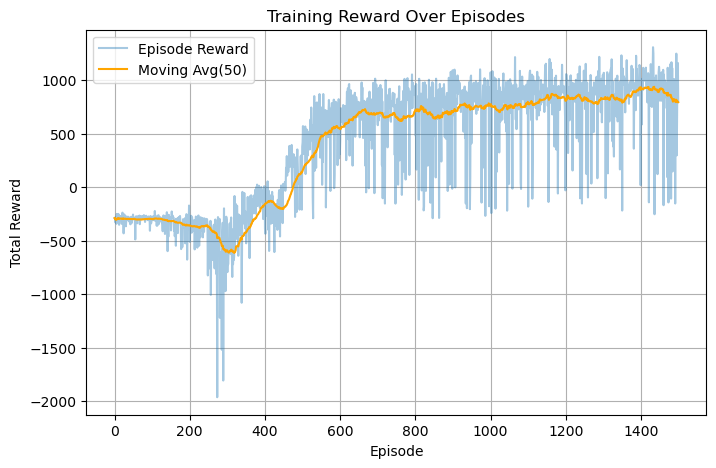

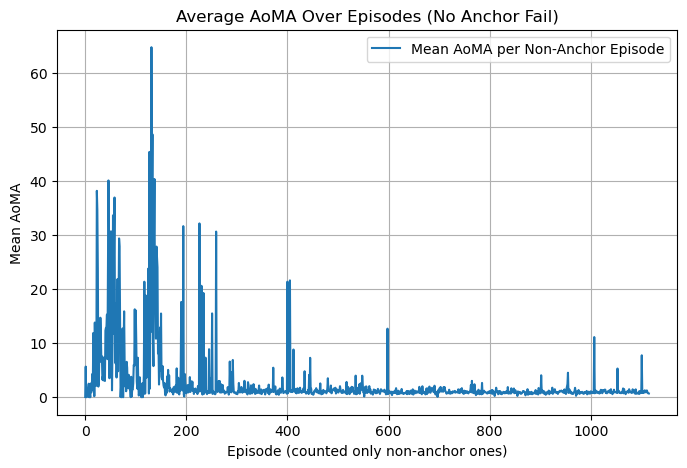

In [58]:
# -------------------------------------------------
# 6. 测试训练并观察结果
# -------------------------------------------------
if __name__ == "__main__":
    trained_agent, reward_hist = train_dqn(num_episodes=1500)

In [79]:
def test_dqn(num_test_episodes=3):
    """
    与 test_dqn 类似，但会在测试过程中
    打印每一步(大步)的状态、AoMA、动作、剩余电量等信息。
    仅建议在少量Episode下使用，输出会比较多。
    """

    # 1. 创建测试环境（参数可与训练一致，也可自定义）
    env = PatrolEnvTimeUnified(
        seed=99
    )

    # 2. 加载模型(假设已有 trained_agent.pth)
    checkpoint = torch.load("trained_agent.pth")
    agent = DQNAgent(
        state_dim=env.state_dim,
        action_dim=env.action_space,
        hidden_dim=64, lr=1e-3,
        gamma=0.99, epsilon_start=1.0,
        epsilon_end=0.0, epsilon_decay=5000,
        buffer_size=50000, batch_size=64,
        seed=42
    )
    agent.q_net.load_state_dict(checkpoint["q_net"])
    agent.target_net.load_state_dict(checkpoint["target_net"])

    # 固定使用贪心策略
    agent.epsilon = 0.0

    # 定义动作ID到动作名称的映射，方便可读性
    action_dict = {
        0: "Go L0",
        1: "Go L1",
        2: "Go Home",
        3: "Wait"
    }

    # 3. 测试循环
    all_rewards = []
    aoma_list = []
    anchor_fail_count = 0

    for ep in range(num_test_episodes):
        s = env.reset()
        done = False
        episode_reward = 0.0
        step_aomas = []
        
        print(f"\n=== Test Episode {ep+1}/{num_test_episodes} ===")
        print(f"Initial State => AoMA_0={s[0]}, AoMA_1={s[1]}, loc={s[2]}, battery={s[3]}")

        step_count = 0
        while not done:
            # 计算当前AoMA并保存
            current_aoma = s[0] + s[1]
            step_aomas.append(current_aoma)

            # 选择动作(纯贪心)
            a = agent.select_action_greedy(s)

            # 执行
            s_next, r, done, info = env.step(a)

            episode_reward += r

            # 打印此时刻的信息
            print(f"  Step {step_count:3d}: "
                  f"AoMA_0={s[0]}, AoMA_1={s[1]}, "
                  f"loc={s[2]}, battery={s[3]:.1f} | "
                  f"Action={action_dict[a]} => Reward={r:.2f}, "
                  f"Done={done}, AnchorFail={info.get('anchor_fail', False)}")

            # 状态转移
            s = s_next
            step_count += 1

        # Episode结束后记录
        all_rewards.append(episode_reward)
        if info.get("anchor_fail", False):
            anchor_fail_count += 1

        avg_aoma = np.mean(step_aomas) if len(step_aomas) > 0 else 0.0
        aoma_list.append(avg_aoma)

        print(f"Episode {ep+1} Finished.  "
              f"TotalReward={episode_reward:.2f}, "
              f"AvgAoMA={avg_aoma:.2f}, "
              f"AnchorFail={info.get('anchor_fail', False)}")

    # 汇总结果
    print("\n=== Test Summary ===")
    print(f"测试了 {num_test_episodes} 个Episode，共发生抛锚 {anchor_fail_count} 次。")

    # 简单可视化
    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(all_rewards, label='Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Test Reward over Episodes')
    plt.legend()
    plt.grid(True)

    plt.subplot(2,1,2)
    plt.plot(aoma_list, label='Average AoMA', color='orange')
    plt.xlabel('Episode')
    plt.ylabel('AoMA')
    plt.title('Average AoMA over Episodes')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "rewards": all_rewards,
        "aoma": aoma_list,
        "anchor_fail_count": anchor_fail_count
    }


rho: 20
抛锚惩罚: 200

=== Test Episode 1/50 ===
Initial State => AoMA_0=0.0, AoMA_1=0.0, loc=2.0, battery=20.0
  Step   0: AoMA_0=0.0, AoMA_1=0.0, loc=2.0, battery=20.0 | Action=Go L0 => Reward=-3.00, Done=False, AnchorFail=False
  Step   1: AoMA_0=0.0, AoMA_1=2.0, loc=0.0, battery=17.0 | Action=Go L1 => Reward=17.00, Done=False, AnchorFail=False
  Step   2: AoMA_0=0.0, AoMA_1=0.0, loc=1.0, battery=15.0 | Action=Go L0 => Reward=15.50, Done=False, AnchorFail=False
  Step   3: AoMA_0=0.0, AoMA_1=1.0, loc=0.0, battery=13.0 | Action=Go L1 => Reward=17.00, Done=False, AnchorFail=False
  Step   4: AoMA_0=0.0, AoMA_1=0.0, loc=1.0, battery=11.0 | Action=Go L0 => Reward=0.00, Done=False, AnchorFail=False
  Step   5: AoMA_0=0.0, AoMA_1=0.0, loc=0.0, battery=9.0 | Action=Go Home => Reward=0.00, Done=False, AnchorFail=False
  Step   6: AoMA_0=0.0, AoMA_1=0.0, loc=2.0, battery=6.0 | Action=Wait => Reward=0.00, Done=False, AnchorFail=False
  Step   7: AoMA_0=0.0, AoMA_1=0.0, loc=2.0, battery=11.0 | Act

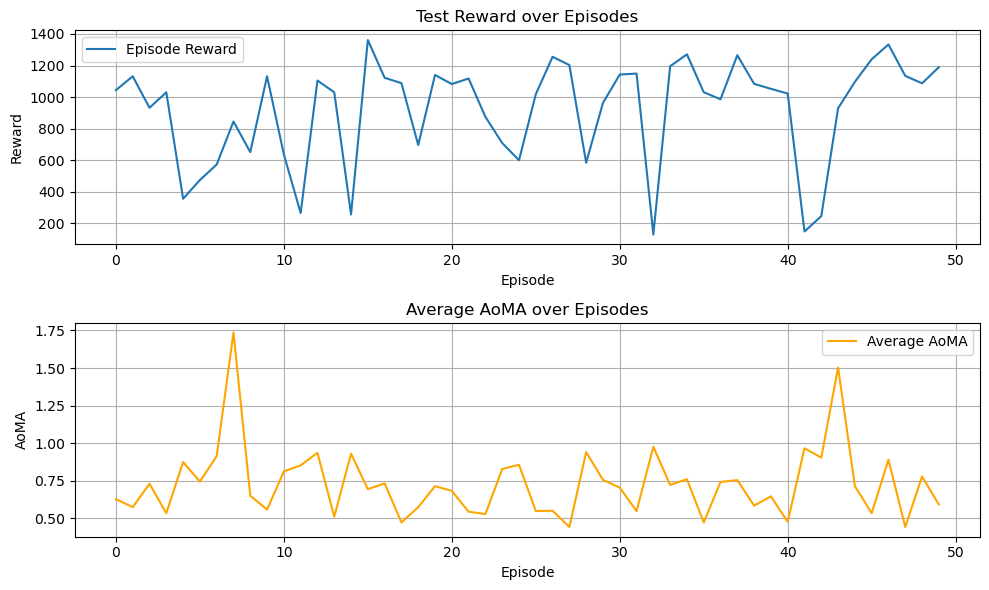

In [80]:
# 例如测试 50 个 Episode
test_results = test_dqn(num_test_episodes=50)
# test_results 中包含 "rewards", "aoma", 以及 "anchor_fail_count"
